In [1]:
"""
Adapted from Track1/find.py
"""
import argparse
import os
import sys
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

In [4]:
print(HERE)
sys.path.insert(0, str(Path(HERE, "..")))  # kinship root
sys.path.insert(0, str(Path(HERE, "..", "rfiw2021")))  # rfiw2021 dir

/warley/dev/research/kinship/notebooks


In [5]:
from dataset import FIW  # noqa: E402
from Track1.models import Net  # noqa: E402
from Track1.utils import set_seed  # noqa: E402

In [6]:
def extract_embeddings(val_loader, model):
    embeddings = []
    labels = []

    for img, family_id in tqdm(val_loader):
        with torch.no_grad():
            embeddings.append(model.encoder(img.cuda()).cpu().numpy())
            labels.append(family_id)

    # Now, embeddings contain all the embeddings from your model
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

In [26]:
def plot_embeddings(embeddings, labels, plot_path):

    # Set up perplexity values
    n_embeddings = len(embeddings)
    perplexities = range(10, n_embeddings, 10)
    print(list(perplexities))

    # Create a color map for families
    color_map = {250: "red", 283: "blue", 409: "green", 735: "purple", 873: "orange"}

    # Define n_subplots based on number of perplexity values
    n_subplots = len(perplexities)
    n_col = 2
    n_row = int(np.ceil(n_subplots / n_col))  # 3 columns

    # Prepare a figure to hold the subplots
    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 5 * n_row))
    axes = axes.flatten()  # Flatten the axes array to make it easier to work with


    # Generate and plot t-SNE for different perplexity values
    for i, perplexity in enumerate(perplexities):
        print(f"Generating t-SNE with perplexity={perplexity}")
        tsne = TSNE(n_components=2, perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(embeddings)

        ax = axes[i]  # Get the current subplot

        # Plot
        for label, color in color_map.items():
            idxs = [idx for idx, val in enumerate(labels) if val == str(label)]
            ax.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], color=color, label=f"Family #0{label}")

        ax.set_title(f"Perplexity: {perplexity}")
        ax.legend()

    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path)
    plt.show()

In [27]:
def setup(root_dir, batch_size, samples_per_member, save_path, gpu: int = 0):
    # Loading and sampling the dataset
    val_dataset = FIW(root_dir=root_dir, families=[250, 283, 409, 735, 873], samples_per_member=samples_per_member)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False)

    # Loading model
    model = Net().cuda()
    model.load_state_dict(torch.load(save_path))
    model.eval()

    set_seed(100)

    return model, val_loader

In [28]:
def run(model, val_loader, plot_path: str = ""):
    # Extracting embeddings
    embeddings, labels = extract_embeddings(val_loader, model)

    # Plotting
    plot_embeddings(embeddings, labels, plot_path)

In [29]:
def parser():
    parser = argparse.ArgumentParser(description="plot embeddings")
    parser.add_argument("--root_dir", type=str, help="root directory of dataset")
    parser.add_argument("--save_path", type=str, help="model save path")
    parser.add_argument("--plot_path", type=str, help="plot save path")
    parser.add_argument("--batch_size", type=int, default=40, help="batch size default 40")
    parser.add_argument("--gpu", default="0", type=str, help="gpu id you use")
    args = parser.parse_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    return args

Family 250 has 5 members
Member MID2 has 5 images
Member MID4 has 2 images
Member MID5 has 1 images
Member MID3 has 7 images
Member MID1 has 8 images
Family 283 has 5 members
Member MID2 has 5 images
Member MID4 has 5 images
Member MID5 has 4 images
Member MID3 has 3 images
Member MID1 has 8 images
Family 409 has 4 members
Member MID2 has 3 images
Member MID4 has 6 images
Member MID3 has 8 images
Member MID1 has 3 images
Family 735 has 4 members
Member MID2 has 5 images
Member MID4 has 1 images
Member MID3 has 4 images
Member MID1 has 9 images
Family 873 has 12 members
Member MID2 has 1 images
Member MID4 has 7 images
Member MID5 has 5 images
Member MID6 has 4 images
Member MID12 has 1 images
Member MID3 has 6 images
Member MID11 has 2 images
Member MID1 has 6 images
Member MID8 has 5 images
Member MID10 has 1 images
Member MID9 has 3 images
Member MID7 has 1 images
Total samples: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


[10, 20]
Generating t-SNE with perplexity=10
Generating t-SNE with perplexity=20


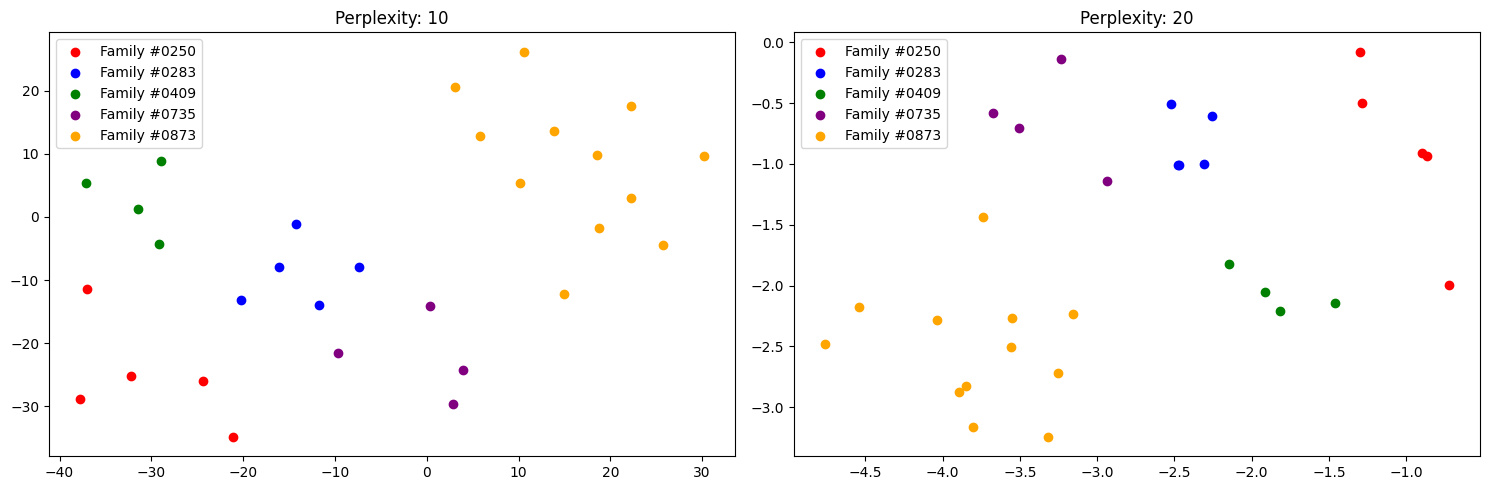

In [30]:
if IS_NOTEBOOK:
    if __name__ == "__main__":
        args = parser()
        run(**vars(args))
else:
    root_dir = Path(HERE, "../rfiw2021/Track1/Validation/val-faces")
    batch_size = 40
    save_path = Path(HERE, "../rfiw2021/Track1/model_track1.pth")
    plot_path = ""
    model, val_loader = setup(root_dir, batch_size, samples_per_member=1, save_path=save_path)
    run(model, val_loader, plot_path)